In [69]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [25]:
#Run a linear regression model on PCA_Dataset_With_Mean and GoogleTrendsTimelineCleaned
#load data
pca_dataset = pd.read_csv('./Data/PCA_Dataset_With_Mean.csv',index_col = 0)
gtrends = pd.read_csv('./Data/GoogleTrendsTimelineCleaned.csv', index_col=0)

In [26]:
pca_dataset.index = pd.to_datetime(pca_dataset.index)
gtrends.index = pd.to_datetime(gtrends.index)


In [28]:
pca_dataset = pd.DataFrame(pca_dataset['PCA_mean'])
pca_dataset

,PCA_mean
Date,
2018-10-07,1.205377
2018-10-14,2.077193
2018-10-21,1.376956
2018-10-28,0.864625
2018-11-04,0.967327
...,...
2021-05-02,5.596290
2021-05-09,5.546458
2021-05-16,3.392458


In [30]:
gtrends.index.rename('Date', inplace = True)
gtrends

,Cryptocurrency,Bitcoin,Ethereum,Bitcoin Cash,Dogecoin
Date,,,,,
2018-10-07,2,8,1,0,0
2018-10-14,2,9,1,0,0
2018-10-21,2,8,1,0,0
2018-10-28,2,8,1,0,0
2018-11-04,2,8,1,1,0
...,...,...,...,...,...
2021-05-02,26,35,18,1,35
2021-05-09,31,43,20,1,35
2021-05-16,30,74,18,1,16


In [34]:
trends_price = gtrends.merge(pca_dataset, on='Date', left_index = True)

,Cryptocurrency,Bitcoin,Ethereum,Bitcoin Cash,Dogecoin
Date,,,,,
2018-10-07,2,8,1,0,0
2018-10-14,2,9,1,0,0
2018-10-21,2,8,1,0,0
2018-10-28,2,8,1,0,0
2018-11-04,2,8,1,1,0
...,...,...,...,...,...
2021-05-02,26,35,18,1,35
2021-05-09,31,43,20,1,35
2021-05-16,30,74,18,1,16


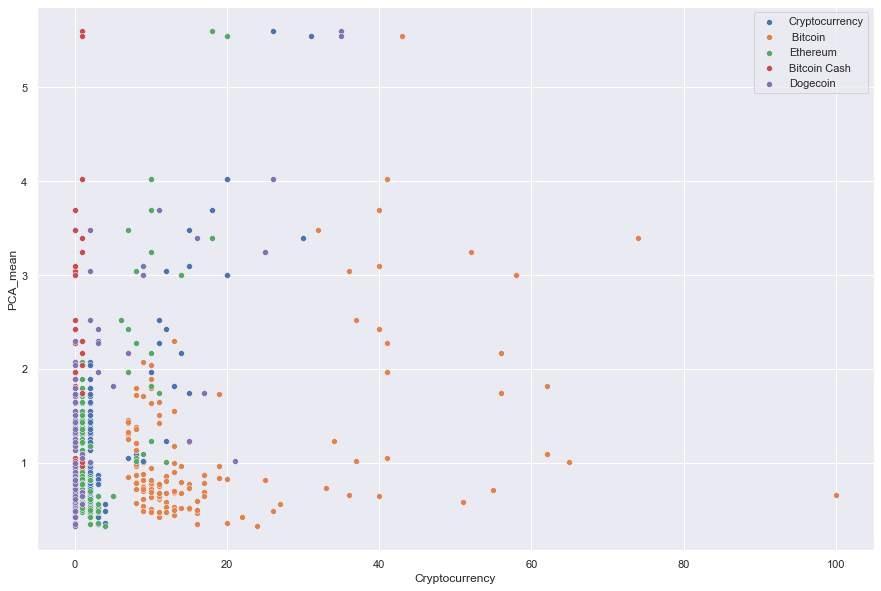

In [57]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x=trends_price['Cryptocurrency'],y=trends_price['PCA_mean'])
sns.scatterplot(x=trends_price['Bitcoin'],y=trends_price['PCA_mean'])
sns.scatterplot(x=trends_price['Ethereum'],y=trends_price['PCA_mean'])
sns.scatterplot(x=trends_price['Bitcoin Cash'],y=trends_price['PCA_mean'])
sns.scatterplot(x=trends_price['Dogecoin'],y=trends_price['PCA_mean'])
plt.legend(labels=['Cryptocurrency',' Bitcoin','Ethereum','Bitcoin Cash','Dogecoin'])
plt.show()

In [176]:
#Create Train Test Spilt

X = trends_price.drop('PCA_mean',axis = 1)
y = trends_price['PCA_mean']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size =0.3, random_state = 2)

In [183]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


#sc = StandardScaler()

#X_train = sc.fit_transform(X_train)

#X_test = sc.transform (X_test)

In [184]:
reg = LinearRegression()
reg.fit(X_train,y_train)

r_sq = reg.score(X_train, y_train)
print('coefficient of determination:', r_sq)

y_pred=reg.predict(X_test)

coefficient of determination: 0.8057696258303351


Our model is about 80.5% accurate

In [185]:
y_pred

array([1.00043667, 0.95329896, 0.5830497 , 0.92872626, 0.9601514 ,
       0.91301369, 0.95229511, 0.95229511, 1.11744436, 0.93658254,
       0.6955932 , 1.14715059, 0.94443883, 0.88158855, 0.74373476,
       0.95307749, 0.95229511, 0.92872626, 0.92872626, 0.35848578,
       0.75259489, 2.00897406, 0.92086997, 0.95329896, 0.9472289 ,
       0.92086997, 5.49240989, 0.92872626, 0.94443883, 0.95229511,
       0.93658254, 0.93859023, 0.94443883, 0.95229511, 0.90616125,
       2.86584928, 0.73487463, 0.92872626, 0.94443883, 0.92872626,
       0.71130577, 0.89730112])

In [193]:
print("The MSE is: {}".format(mean_squared_error(y_test, y_pred)))
print('The MAE is: {}'.format(mean_absolute_error(y_test, y_pred)))

The MSE is: 0.31296245766792685
The MAE is: 0.40369159284724737


From the MAE, on average our prediction is about 0.40 off from the true value

In [89]:
#Visualize Linear Regression?